# Summary
| |  |
|:----------|:---|
|**Step 1** | Load and Transform Data    |
|**Step 2** | Defining custom functions          |
|**Step 3** | Preprocess Base |
|**Step 4** | Adjusting Database for Model Training |
|**Step 5** | Creating and Training the Model |
|**Step 6** | Evaluating the Model |

In [1]:
# Libraries:
import spacy
import string
import pandas as pd
import numpy as np
import seaborn as sns
from spacy.lang.pt.stop_words import STOP_WORDS
from spacy.training.example import Example
from zipfile import ZipFile
from google.colab import files


In [3]:
# Install portuguese pack:
!python3 -m spacy download pt_core_news_sm;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 36.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### **Step 1: Load and Transform Data**

The split dataset is loaded into the session. Both files were processed in previous code.

In [3]:
base_test = pd.read_csv('/content/base_news_pt_test.csv', encoding = 'utf-8')
base_train = pd.read_csv('/content/base_news_pt_train.csv', encoding = 'utf-8')

# Convert the sentiment into categogical data:
base_train['Sentiment'] = base_train['Sentiment'].astype('category')
base_test['Sentiment'] = base_test['Sentiment'].astype('category')

base_train.head()

,Sentiment,Text PT
0,neutral,"Em 2010, a Sanoma Magazines espera que as vend..."
1,neutral,O valor deste tipo de encomenda situa-se norma...
2,neutral,As empresas finlandesas L+�nnen Tehtaat e Rais...
3,neutral,"O PC completo pesa 1,25 kg e tem pouco mais de..."
4,neutral,"Aho está orgulhoso do novo produto da empresa,..."


### **Step 2: Define Custom Functions**



In [4]:
# Stop words and ponctuation:
stop_words = STOP_WORDS
ponctuation = string.punctuation

# Loads a pre-trained model for Portuguese:
NLP = spacy.load("pt_core_news_sm")


# Function to preprocess the text:
def preprocess(text):
  text = text.lower() # Convert text to lowercase
  doc = NLP(text)     # Creating an object
  list = []           # Initialize output


 # Lemmatization: reduces words to their base form to help with text analysis.
  for token in doc:
    list.append(token.lemma_)

  # Remove stop words and ponctuation:
  list = [word for word in list if word not in stop_words and word not in ponctuation]
  # Remove digits:
  list = ' '.join([str(entry) for entry in list if not entry.isdigit()])

  return list

### **Step 3: Preprocess Base**

Both DataFrames are preprocessed and a new column is added in each.

In [5]:
base_train['PP Text'] = base_train['Text PT'].apply(preprocess)
base_test['PP Text'] = base_test['Text PT'].apply(preprocess)

base_train.head()

,Sentiment,Text PT,PP Text
0,neutral,"Em 2010, a Sanoma Magazines espera que as vend...",sanoma magazine esperar venda líquir ficar em o
1,neutral,O valor deste tipo de encomenda situa-se norma...,de este encomenda situar se normalmente milhão...
2,neutral,As empresas finlandesas L+�nnen Tehtaat e Rais...,empresa finlandês l+ � em nen tehtaat raisio d...
3,neutral,"O PC completo pesa 1,25 kg e tem pouco mais de...","pc completo pesa 1,25 kg centímetro espessura"
4,neutral,"Aho está orgulhoso do novo produto da empresa,...",aho orgulhoso de o produto de o empresa lordi-...


### **Step 4: Adjusting Database for Model Training**

Both datasets are adjusted to build the model. For each row, the sentiment (positive, negative, or neutral) is mapped to a dictionary and appended as a pair to a new list.

In [6]:
# Train DataFrame transformed into list with new embedded dictionary:
train_list = []

for text, sentiment in zip(base_train['PP Text'], base_train['Sentiment']):
  if sentiment == 'positive':
    dic = ({'POSITIVE': True, 'NEGATIVE': False, 'NEUTRAL': False})
  elif sentiment == 'negative':
    dic = ({'POSITIVE': False, 'NEGATIVE': True, 'NEUTRAL': False})
  elif sentiment == 'neutral':
    dic = ({'POSITIVE': False, 'NEGATIVE': False, 'NEUTRAL': True})

  train_list.append([text, dic.copy()])

# Shows output:
train_list[0]

['sanoma magazine esperar venda líquir ficar em o',
 {'POSITIVE': False, 'NEGATIVE': False, 'NEUTRAL': True}]

In [7]:
# Test DataFrame transformed into list with new embedded dictionary:
test_list = []

for text, sentiment in zip(base_test['PP Text'], base_test['Sentiment']):
  if sentiment == 'positive':
    dic = ({'POSITIVE': True, 'NEGATIVE': False, 'NEUTRAL': False})
  elif sentiment == 'negative':
    dic = ({'POSITIVE': False, 'NEGATIVE': True, 'NEUTRAL': False})
  elif sentiment == 'neutral':
    dic = ({'POSITIVE': False, 'NEGATIVE': False, 'NEUTRAL': True})

  test_list.append([text, dic.copy()])

# Shows output:
test_list[0]

['empresa atender cliente setor incluir processo recurso máquina industrial arquitetura construção eletricidade transporte eletrônico química petroquímica energia tecnologia de o informação alimentação residência',
 {'POSITIVE': False, 'NEGATIVE': False, 'NEUTRAL': True}]

### **Step 5: Creating and Training the Model**

The code below creates and trains a text classification model in Portuguese using spaCy. An optimizer is initialized, and the training runs for 200 epochs. During training, the data is split into batches of size 10, and each text is converted into training examples linked to their respective categories. These examples are used to update the model's weights and compute the losses, which are printed every 10 epochs to track the learning progress.

In [8]:
# Create an empty portuguese model:
model = spacy.blank('pt')

# Adds the TextCategorizer: specifically designed for multi-label or single-label text classification.
categories = model.add_pipe('textcat')

# Adds labels for classification
categories.add_label("POSITIVE")
categories.add_label("NEGATIVE")
categories.add_label("NEUTRAL")

# List to store the historic
hist = []


# Begin Training
optimizer = model.begin_training()

# Training loop:
for epoch in range(200):
    losses = {}

    for batch in spacy.util.minibatch(train_list, size=10):
        examples = []
        for text, entities in batch:
            doc = model.make_doc(text)
            ex = Example.from_dict(doc, {'cats': entities})
            examples.append(ex)

        # Update model from examples
        model.update(examples=examples, losses=losses, sgd=optimizer)

    # Print losses over epochs
    if epoch % 10 == 0:
        print(f"Losses in epoch {epoch}: {losses}")

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


Losses in epoch 0: {'textcat': 53.09265183378011}
Losses in epoch 10: {'textcat': 3.223717442030838}
Losses in epoch 20: {'textcat': 2.0942296014676858}
Losses in epoch 30: {'textcat': 0.978668573429192}
Losses in epoch 40: {'textcat': 0.4785097413558598}
Losses in epoch 50: {'textcat': 0.11792130226076002}
Losses in epoch 60: {'textcat': 0.19247067758689299}
Losses in epoch 70: {'textcat': 0.08646937539080897}
Losses in epoch 80: {'textcat': 0.1036129817055652}
Losses in epoch 90: {'textcat': 0.08188146362654161}
Losses in epoch 100: {'textcat': 0.13693066915223367}
Losses in epoch 110: {'textcat': 0.41511214453358747}
Losses in epoch 120: {'textcat': 0.10624977946706068}
Losses in epoch 130: {'textcat': 0.058062951138406316}
Losses in epoch 140: {'textcat': 0.12923446438527328}
Losses in epoch 150: {'textcat': 0.05966278961778076}
Losses in epoch 160: {'textcat': 1.3874390991668126}
Losses in epoch 170: {'textcat': 0.05290106342231403}
Losses in epoch 180: {'textcat': 0.0553427987765

In [10]:
import shutil

# Save trained model:
model.to_disk('Sentiment Model')

# Zip model:
shutil.make_archive('Sentiment_Model', 'zip', 'Sentiment Model')

# Download model:
files.download('Sentiment_Model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Step 6: Evaluating the Model**

The sentiment analysis model is tested and its performance is measured by relevant metrics.
1. The model makes predictions for each test text, and compares them with the true labels. For each text, the model’s predicted label is the one with the highest score, while the true label is determined from the dataset.

2. After collecting both predicted and true labels, the code calculates performance metrics using classification_report and generates a confusion matrix to visualize the model's performance.

In [11]:
# Libraries:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [12]:
# Creating model predictions using the test list:
predicted_labels = []
true_labels = []

for text, labels in test_list:
    # Model predictions:
    doc = model(text)
    predicted_label = max(doc.cats, key=doc.cats.get)  # Label with greater score
    predicted_labels.append(predicted_label)

    # True label (from dataset)
    true_label = max(labels, key=labels.get)  # Label assigned with True
    true_labels.append(true_label)

In [13]:
# Performance metrics:
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["POSITIVE", "NEGATIVE", "NEUTRAL"]))

Classification Report:
              precision    recall  f1-score   support

    POSITIVE       0.69      0.66      0.68       152
    NEGATIVE       0.78      0.85      0.81       704
     NEUTRAL       0.68      0.58      0.62       354

    accuracy                           0.74      1210
   macro avg       0.72      0.69      0.70      1210
weighted avg       0.74      0.74      0.74      1210



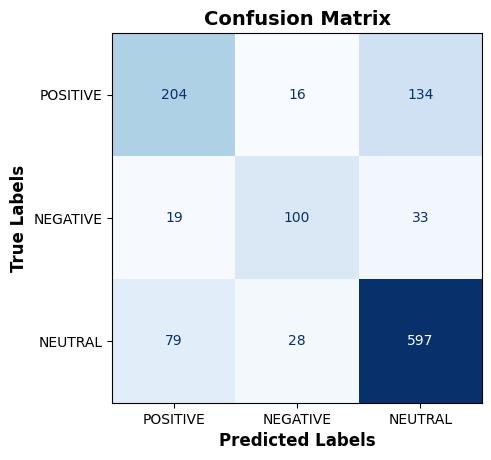

In [14]:
# Computing confusion matrix:
cm = confusion_matrix(true_labels, predicted_labels, labels=["POSITIVE", "NEGATIVE", "NEUTRAL"])

# Create figure object:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["POSITIVE", "NEGATIVE", "NEUTRAL"])

# Settings:
disp.plot(cmap=plt.cm.Blues, values_format='d', colorbar = False)
plt.title("Confusion Matrix", fontsize=14, fontweight='semibold')
plt.grid(False)

# Outer labels:
plt.xlabel('Predicted Labels', fontsize=12, fontweight='semibold')
plt.ylabel('True Labels', fontsize=12, fontweight='semibold')

# Inner labels:
plt.gca().set_xticklabels(["POSITIVE", "NEGATIVE", "NEUTRAL"], fontsize=10)
plt.gca().set_yticklabels(["POSITIVE", "NEGATIVE", "NEUTRAL"], fontsize=10)

plt.show()

---